In [110]:
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pytorch_lightning as pl
import sys 
import torch

sys.path.append("..")
from src.models import Model
from src.models.data import CropDataset, BoundingBox
from src.datasets_labeled import labeled_datasets

In [156]:
prediction_dfs = {}
for model_name in ["Kenya", "Togo"]:
    model = Model.load_from_checkpoint(f"../data/models/{model_name}.ckpt")
    model = model.eval()
    datasets = [d for d in labeled_datasets if d.dataset == model_name]
    val = CropDataset(
        data_folder=Path("../data"),
        subset="validation",
        datasets=datasets,
        cache=None,
        noise_factor=0.1,
        probability_threshold=0.5,
        remove_b1_b10=True,
        normalizing_dict=model.normalizing_dict,
        upsample=False,
        target_bbox=model.target_bbox,
        is_local_only=True,
        is_global_only=False,
    )
    
    # Load validation dataset (python objects)
    instances = []
    for i, target_file in tqdm(enumerate(val.pickle_files)):
        with target_file.open("rb") as f:
            instance = pickle.load(f)
            assert val[i][1].numpy() == instance.crop_probability
            instances.append(instance)
    
    # Make predictions
    def tensor_to_pred(y, threshold=0.5):
        y = y.numpy().flatten()
        y[y > threshold] = 1
        y[y <= threshold] = 0
        return y

    x = torch.stack([v[0] for v in val])
    #x = model.add_noise(x, training=False)
    with torch.no_grad():
        y_global_tensor, y_local_tensor = model(x)

    y_true = np.array([1 if inst.crop_probability > 0.5 else 0 for inst in instances])
    y_local = tensor_to_pred(y_local_tensor, threshold=0.5)
    assert len(y_true) == len(y_local)
    
    df = pd.DataFrame({"preds": y_local, "label": y_true})
    
    prediction_dfs[model_name] = df
    

100%|██████████| 861/861 [00:00<00:00, 17863.11it/s]

BEFORE UPSAMPLING: pickle_files: 63186
Upsampling: local training crop: 5920 to non-crop: 8447
AFTER UPSAMPLING: pickle_files: 65713


0it [00:00, ?it/s]

100%|██████████| 277/277 [00:00<00:00, 3233.11it/s]

BEFORE UPSAMPLING: pickle_files: 63186
Upsampling: local training crop: 532 to non-crop: 508
AFTER UPSAMPLING: pickle_files: 63210


0it [00:00, ?it/s]

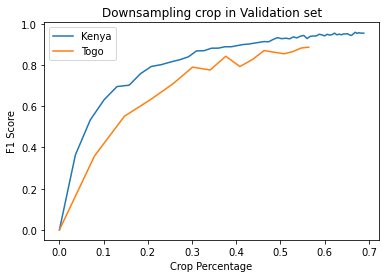

In [159]:
# Downsampling crop
for model_name, df in prediction_dfs.items():
    total_crop_amount = len(df[df["label"] == 1])

    crop_pcts = []
    f1_scores = []
    for n in np.arange(0, total_crop_amount, 10):
        different_validation_set = pd.concat([
             df[df["label"] == 1].sample(n=n, replace=True),
            df[df["label"] == 0]
        ])
        crop_pcts.append(n / len(different_validation_set))
        score = f1_score(different_validation_set["label"], different_validation_set["preds"])
        f1_scores.append(score)
        
    plt.plot(crop_pcts, f1_scores, label=model_name)
    plt.legend()
    plt.xlabel("Crop Percentage")
    plt.ylabel("F1 Score")
    plt.title(f"Downsampling crop in Validation set");